# QM7 Dataset

## Description

This dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules.

The dataset is composed of three multidimensional arrays X (7165 x 23 x 23), T (7165) and P (5 x 1433) representing the inputs (Coulomb matrices), the labels (atomization energies) and the splits for cross-validation, respectively. The dataset also contain two additional multidimensional arrays Z (7165) and R (7165 x 3) representing the atomic charge and the cartesian coordinate of each atom in the molecules.

## Idea of my implementation

- Use the arrays Z (atomic charge) and R (cartesian coordinate) to generate a `.xyz` file
- Convert this `.xyz` file to molecular graph structure data
- GCN on graph structure data

## Generate 7165 `.xyz` file

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdmolfiles
from rdkit.Chem import AllChem

In [2]:
import scipy.io
import numpy as np

qm7 = scipy.io.loadmat('qm7.mat')
R = qm7['R']
Z = qm7['Z']
T = qm7['T'][0]

In [3]:
charge_to_atom = {
    1 : 'H',
    6 : 'C',
    7 : 'N',
    8 : 'O',
    16: 'S'
}

# unit Bohr to A
BohrToA = 0.529177249

# hybridization state one-hot encoding
HybridizationToFeature = {
    rdkit.Chem.rdchem.HybridizationType.SP3 : 4,
    rdkit.Chem.rdchem.HybridizationType.SP2 : 3,
    rdkit.Chem.rdchem.HybridizationType.SP  : 2,
    rdkit.Chem.rdchem.HybridizationType.S   : 1
}

In [4]:
for i in range(len(Z)):
    filename = f"xyz_file/qm7_xyz_{i+1}.xyz"
    atoms = []
    coordinates = []
    with open(filename, "w") as xyz:
        for j in range(len(Z[i])):
            if int(Z[i][j]) != 0:
                atoms.append(charge_to_atom[int(Z[i][j])])
                coordinates.append(R[i][j]*BohrToA)
        xyz.write(f"{len(atoms)}\n\n")
        for k in range(len(atoms)):
            xyz.write(f"{atoms[k]}  {coordinates[k][0]:.10f} {coordinates[k][1]:.10f} {coordinates[k][2]:.10f}\n")

## Convert `.xyz` file to MolGraph

In [5]:
# convert each xyz to molecular graph
mols = []
for i in range(7165):
    filename = f"xyz_file/qm7_xyz_{i+1}.xyz"
    mol = rdmolfiles.MolFromXYZFile(filename)
    mols.append(mol)

In [24]:
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_3d = True

In [25]:
# # make 3d mol graph
# import py3Dmol
# def draw_with_spheres(mol):
#     v = py3Dmol.view(width=300,height=300)
#     IPythonConsole.addMolToView(mol,v)
#     v.zoomTo()
#     v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
#     v.show()

In [6]:
# determine chemical bonds between each atom

from rdkit.Chem import rdDetermineBonds

for mol in mols: rdDetermineBonds.DetermineBonds(mol, charge=0)

## Graph Convolutional Network

In [7]:
# import required packages for graph convolutional network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [9]:
# build a 5-layer graph convolutional network (GCN) containing edge_index and edge_attr
# return the predicted energy of each molecule
class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = gnn.GCNConv(num_features, 64)
        self.conv2 = gnn.GCNConv(64, 64)
        self.conv3 = gnn.GCNConv(64, 64)
        self.conv4 = gnn.GCNConv(64, 64)
        self.conv5 = gnn.GCNConv(64, 64)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = F.relu(self.conv4(x, edge_index, edge_attr))
        x = F.relu(self.conv5(x, edge_index, edge_attr))
        x = gnn.global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

In [10]:
# Calculate adjacency matrices for each molecule
adj_matrices = []
for mol in mols:
    adj_matrix = Chem.rdmolops.GetAdjacencyMatrix(mol)
    adj_matrices.append(adj_matrix)

# Make sure all adjacency matrices have the same dimension
max_atoms = max([adj.shape[0] for adj in adj_matrices])
for i in range(len(adj_matrices)):
    pad_width = max_atoms - adj_matrices[i].shape[0]
    adj_matrices[i] = np.pad(adj_matrices[i], pad_width=((0, pad_width), (0, pad_width)), mode='constant', constant_values=0)

# Calculate edge indices for each molecule
edge_indices = []
for adj in adj_matrices:
    edge_index = np.array(np.where(adj == 1)).T
    edge_indices.append(edge_index)

# Calculate edge attributes for each molecule
edge_attrs = []
for mol in mols:
    edge_attr = []
    for bond in mol.GetBonds():
        edge_attr.append(bond.GetBondTypeAsDouble())
    edge_attrs.append(edge_attr)

# Make sure all edge indices have the same dimension
max_edges = max([edge_index.shape[0] for edge_index in edge_indices])
for i in range(len(edge_indices)):
    pad_width = max_edges - edge_indices[i].shape[0]
    edge_indices[i] = np.pad(edge_indices[i], pad_width=((0, pad_width), (0, 0)), mode='constant', constant_values=0)

# Pad edge attributes corresponding to non-existing edges with zeros
for i in range(len(edge_attrs)):
    pad_width = max_edges - len(edge_attrs[i])
    edge_attrs[i] = np.pad(edge_attrs[i], pad_width=(0, pad_width), mode='constant', constant_values=0)

# Calculate node features for each molecule
node_features = []
for mol in mols:
    node_feature = []
    for atom in mol.GetAtoms():
        node_feature.append(atom.GetAtomicNum())
    node_features.append(node_feature)

# Make sure all node features have the same dimension (number of atoms, 1)
max_atoms = max([len(node_feature) for node_feature in node_features])
for i in range(len(node_features)):
    pad_width = max_atoms - len(node_features[i])
    node_features[i] = np.pad(node_features[i], pad_width=(0, pad_width), mode='constant', constant_values=0)

# Add atomic coordinates R matrix as node features
for i in range(len(mols)):
    coordinates = np.transpose(R[i])
    node_features[i] = np.concatenate(([node_features[i]], coordinates), axis=0)

# Add another node feature as hybridization of each atom
for i in range(len(mols)):
    hybridization = []
    for atom in mols[i].GetAtoms():
        hybridization.append(HybridizationToFeature[atom.GetHybridization()])
    while len(hybridization) < max_atoms:
        hybridization.append(0)
    # add zeros to the end of the list to make sure the length of the list is the same as the number of atoms
    node_features[i] = np.concatenate((node_features[i], [hybridization]), axis=0)

# Make a list of torch_geometric.data.Data objects
data_list = []
for i in range(len(mols)):
    data = Data(x=torch.tensor(np.transpose(node_features[i]), dtype=torch.float), 
                edge_index=torch.tensor(edge_indices[i], dtype=torch.long).T, 
                edge_attr=torch.tensor(edge_attrs[i], dtype=torch.float).unsqueeze(1), 
                y=torch.tensor(T[i], dtype=torch.float)
)
    data_list.append(data)


In [11]:
# Define training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [12]:
# Define validation function
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    for data in loader:
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [13]:
# Define test function
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    for data in loader:
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [16]:
# Split data into training, validation, and test sets
from torch.utils.data import random_split
torch.manual_seed(42)
train_data, val_data, test_data = random_split(data_list, [0.8, 0.1, 0.1])

In [33]:
# define number of features and number of classes
num_features = 5
num_classes = 1
# define epochs
epochs = 1000
# define learning rate
lr = 0.01
# define batch size
batch_size = 32

# define model
model = GCN(num_features, num_classes)
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# define loss function
criterion = nn.MSELoss()

# define training loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# define validating loader
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# define testing loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# train model
train_loss_data = []
val_loss_data = []
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Validate Loss: {val_loss:.4f}')

Epoch: 001, Loss: 161654.4114, Validate Loss: 11900.1381
Epoch: 002, Loss: 10852.6137, Validate Loss: 10153.6009
Epoch: 003, Loss: 10624.4380, Validate Loss: 11152.3980
Epoch: 004, Loss: 11051.7674, Validate Loss: 9989.5918
Epoch: 005, Loss: 10635.7336, Validate Loss: 10473.0229
Epoch: 006, Loss: 10676.8630, Validate Loss: 8897.8709
Epoch: 007, Loss: 9929.4256, Validate Loss: 10299.5861
Epoch: 008, Loss: 9788.7891, Validate Loss: 10585.7255
Epoch: 009, Loss: 10062.6974, Validate Loss: 11956.3429
Epoch: 010, Loss: 10488.6765, Validate Loss: 8348.4671
Epoch: 011, Loss: 10328.3938, Validate Loss: 10075.8702
Epoch: 012, Loss: 9042.2954, Validate Loss: 16577.8535
Epoch: 013, Loss: 10417.8732, Validate Loss: 8143.7312
Epoch: 014, Loss: 10123.6699, Validate Loss: 11132.0781
Epoch: 015, Loss: 10415.2774, Validate Loss: 7664.2732
Epoch: 016, Loss: 9076.2390, Validate Loss: 8897.9296
Epoch: 017, Loss: 9180.6242, Validate Loss: 17393.0885
Epoch: 018, Loss: 9325.0179, Validate Loss: 11604.0921
Epo

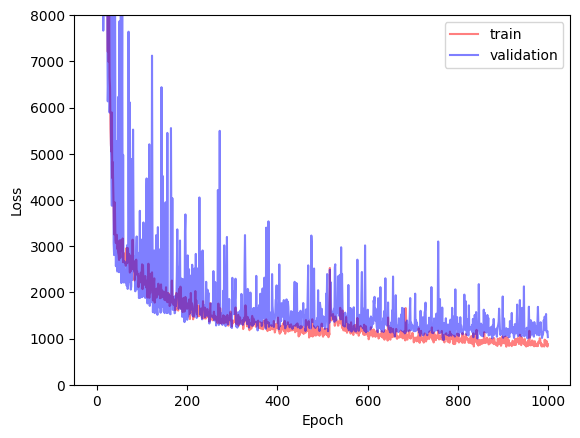

In [38]:
# plot the learning curve
# ylabel from 800 to 4000
import matplotlib.pyplot as plt
plt.plot(train_loss_data, label='train', color='red', alpha=0.5)
plt.plot(val_loss_data, label='validation', color='blue', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 8000)
plt.legend()

r2_score: 0.9770027122757571
RMSE: 33.29566955566406
MAE: 25.223665237426758


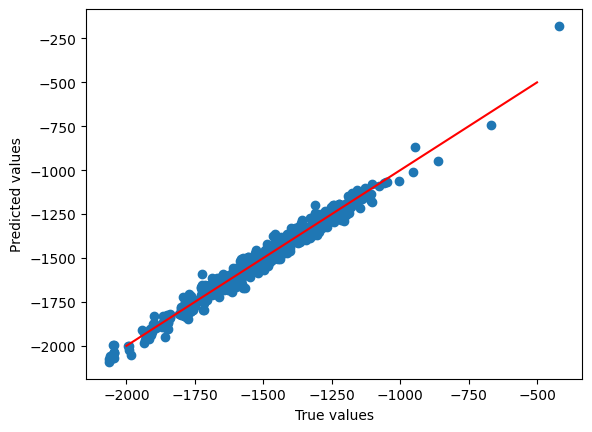

In [36]:
# predict on test set
model.eval()
preds = []
for data in test_loader:
    out = model(data)
    preds.append(out.detach().numpy())
preds = np.concatenate(preds)

# calculate R2 score
from sklearn.metrics import r2_score
trues = np.concatenate([data.y.detach().numpy() for data in test_loader])
print(f"r2_score: {r2_score(trues, preds)}")

# calculate RMSE
from sklearn.metrics import mean_squared_error
print(f"RMSE: {np.sqrt(mean_squared_error(trues, preds))}")

# calculate MAE
from sklearn.metrics import mean_absolute_error
print(f"MAE: {mean_absolute_error(trues, preds)}")

# plot a scatter plot of predicted vs. true values
# add a red line to show the perfect prediction
plt.scatter(trues, preds)
plt.plot([-2000, -500], [-2000, -500], 'red')
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.savefig('gcnmodel.png')